In [1]:
%%configure -f
{
    "conf": {
        "spark.jars.packages": "com.databricks:spark-xml_2.12:0.14.0",
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
sc.install_pypi_package("pandas==1.1.0")
sc.install_pypi_package("matplotlib==3.0.0")
from pyspark.sql.functions import ceil, col, count, desc, unix_timestamp, window
import matplotlib.pyplot as plot

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1644004640939_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
postsXmlPath = 's3://kn-praca-dyplomowa-sports/superuser_data/Posts.xml'
postsParquetPath = 's3://kn-praca-dyplomowa-sports/superuser_data/out/Posts'
postHistoryXmlPath = 's3://kn-praca-dyplomowa-sports/superuser_data/PostHistory.xml'
postHistoryParquetPath = 's3://kn-praca-dyplomowa-sports/superuser_data/out/PostHistory'
commentsXmlPath = 's3://kn-praca-dyplomowa-sports/superuser_data/Comments.xml'
commentsParquetPath = 's3://kn-praca-dyplomowa-sports/superuser_data/out/Comments'
usersXmlPath = 's3://kn-praca-dyplomowa-sports/superuser_data/Users.xml'
usersParquetPath = 's3://kn-praca-dyplomowa-sports/superuser_data/out/Users'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Map from xml to parquet in S3 with Spark

(
spark
.read
.format('xml')
.option("rowTag", "row")
.load(postsXmlPath)
.select(
    col('_Id').alias('id'),
    col('_PostTypeId').alias('postTypeId'),
    col('_AcceptedAnswerId').alias('acceptedAnswerId'),
    (col('_CreationDate').cast('timestamp')).alias('creationDate'),
    col('_OwnerUserId').alias('ownerUserId'),
    col('_ParentId').alias('parentId'),
    col('_Score').alias('score'),
    col('_ViewCount').alias('viewCount')
)
.write
.mode('overwrite')
.format('parquet')
.option('path', postsParquetPath)
.save()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
posts = spark.read.parquet(postsParquetPath).select(
    'id',
    'postTypeId',
    'acceptedAnswerId',
    'creationDate',
    'ownerUserId',
    'parentId',
    'score',
    'viewCount',
).cache()

posts.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|summary|                id|        postTypeId| acceptedAnswerId|      ownerUserId|         parentId|            score|         viewCount|
+-------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|  count|           1159934|           1159934|           192647|          1130323|           682102|          1159934|            470283|
|   mean| 818774.4867690748|1.6108951026523923|747775.3927182879|319091.3533591725|695777.3822038346|2.781882417447889| 5775.582532219961|
| stddev|491414.04362879833|0.5447973665771906|480786.0776756186|353765.7197700805|480105.0488046648|13.98879720518215|27673.666872868638|
|    min|                 1|                 1|               42|               -1|                1|              -69|                 2|
|    max|           1691314

In [6]:
posts.groupBy('postTypeId').agg(count('*').alias('count')).orderBy(desc('count')).limit(10).toPandas().plot(
    title='Number of post per post type',
    x='postTypeId',
    xlabel='post type',
    y='count',
    ylabel='number of posts',
    kind='bar',
    legend=False
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

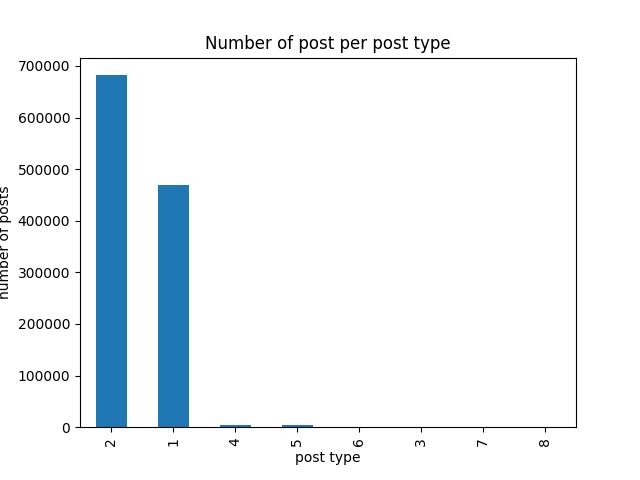

In [7]:
%matplot plot

In [8]:
(
spark
.read
.format('xml')
.option("rowTag", "row")
.load(postHistoryXmlPath)
.select(
    col('_Id').alias('id'),
    col('_PostHistoryTypeId').alias('postHistoryTypeId'),
    col('_PostId').alias('postId'),
    col('_UserDisplayName').alias('userDisplayName'),
    col('_UserId').alias('userId'),
    (col('_CreationDate').cast('timestamp')).alias('creationDate')
)
.write
.mode('overwrite')
.format('parquet')
.option('path', postHistoryParquetPath)
.save()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
postHistory = spark.read.parquet(postHistoryParquetPath).cache()

postHistory.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+-----------------+------------------+--------------------+------------------+
|summary|               id|postHistoryTypeId|            postId|     userDisplayName|            userId|
+-------+-----------------+-----------------+------------------+--------------------+------------------+
|  count|          3309494|          3309494|           3309494|              102291|           3101151|
|   mean|2908340.356300389|5.797867589426057| 816979.6769267446|            Infinity|296849.21729286964|
| stddev|1913296.069003844|9.800562814224646|481733.34386547236|                 NaN| 350279.7427222432|
|    min|                1|                1|                 1|                 ...|                -1|
|    max|          6417901|               53|           1691315|              이광수|           1646794|
+-------+-----------------+-----------------+------------------+--------------------+------------------+

In [10]:
postHistory.groupBy('postHistoryTypeId').agg(count('*').alias('count')).orderBy(desc('count')).limit(10).toPandas().plot(
    title='Number of post history entries per type',
    x='postHistoryTypeId',
    xlabel='post history type',
    y='count',
    ylabel='number of history entries',
    kind='bar',
    legend=False
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

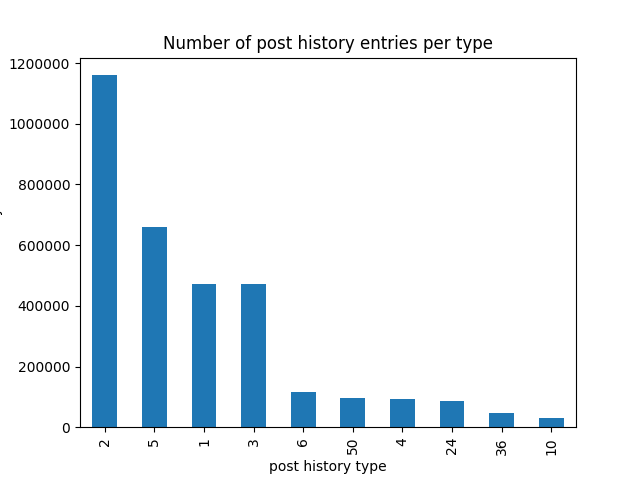

In [11]:
%matplot plot

In [12]:
(
spark
.read
.format('xml')
.option("rowTag", "row")
.load(commentsXmlPath)
.select(
    col('_Id').alias('id'),
    col('_PostId').alias('postId'),
    col('_Score').alias('score'),
    col('_UserDisplayName').alias('userDisplayName'),
    col('_UserId').alias('userId'),
    (col('_CreationDate').cast('timestamp')).alias('creationDate')
)
.write
.mode('overwrite')
.format('parquet')
.option('path', commentsParquetPath)
.save()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
comments = spark.read.parquet(commentsParquetPath).cache()

comments.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----------------+-------------------+--------------------+-----------------+
|summary|                id|           postId|              score|     userDisplayName|           userId|
+-------+------------------+-----------------+-------------------+--------------------+-----------------+
|  count|           1715009|          1715009|            1715009|               41838|          1672905|
|   mean|1288584.4733211312|861431.0809989918|0.37343535806517636|  2042484.2222222222|283587.2349553621|
| stddev| 760249.9015245036|475601.8808441577| 1.9892390586296198|  3527789.0424768096|315561.8448748035|
|    min|                32|                1|                  0|                 ...|               -1|
|    max|           2600318|          1691310|                365|              이광수|          1646746|
+-------+------------------+-----------------+-------------------+--------------------+-----------------+

In [14]:
questions = posts.filter(col('postTypeId') == 1).cache()
answers = posts.filter(col('postTypeId') == 2).cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
commentTimeInSecs = (
    questions.alias('questions')
    .join(comments.alias('comments'), col('questions.id') == col('comments.postId'))
    .select(
        col('questions.id'),
        col('questions.creationDate').alias('questionCreationDate'),
        col('comments.creationDate').alias('commentCreationDate')
    )
    .withColumn('commentTimeInSecs', unix_timestamp('commentCreationDate') - unix_timestamp('questionCreationDate'))
    .filter(col('commentTimeInSecs') > 0)
    .orderBy('commentTimeInSecs')
)

commentTimeInSecs.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+
|summary|                id| commentTimeInSecs|
+-------+------------------+------------------+
|  count|            881300|            881300|
|   mean| 959708.7515965052| 4659149.690460683|
| stddev|453699.06053573964|2.55753034130819E7|
|    min|                 1|                 4|
|    max|           1691310|         405883625|
+-------+------------------+------------------+

In [32]:
commentsWithin60minutes = (
    commentTimeInSecs
    .withColumn('minutes', ceil(col('commentTimeInSecs') / 60))
    .groupBy('minutes')
    .agg(count('*').alias('count'))
    .orderBy('minutes')
    .limit(60)
).toPandas()

commentsWithin60minutes.plot(
    title='Number of comments to questions within first 60 minutes',
    x='minutes',
    xlabel='Time after question published in minutes',
    y='count',
    ylabel='Number of comments',
    kind='bar',
    legend=False,
    figsize=(15,7), 
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

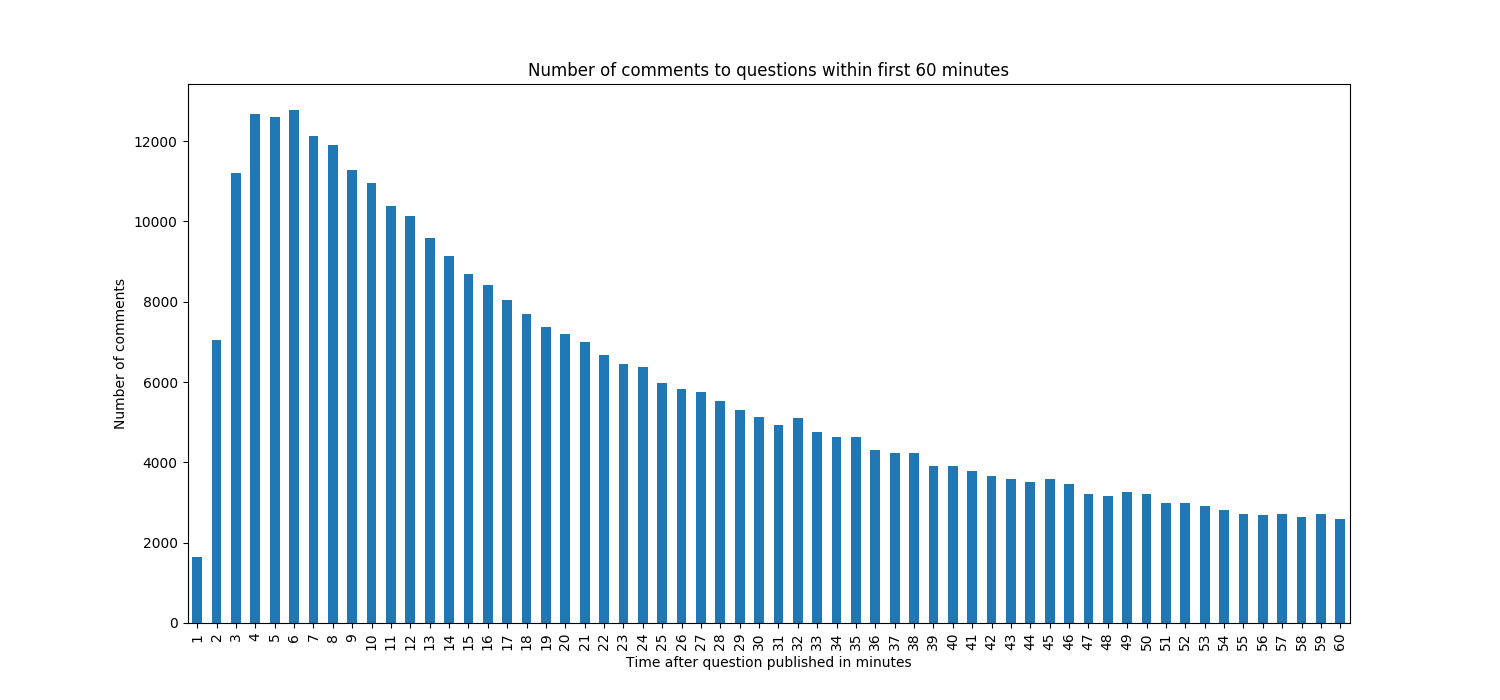

In [35]:
%matplot plot

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

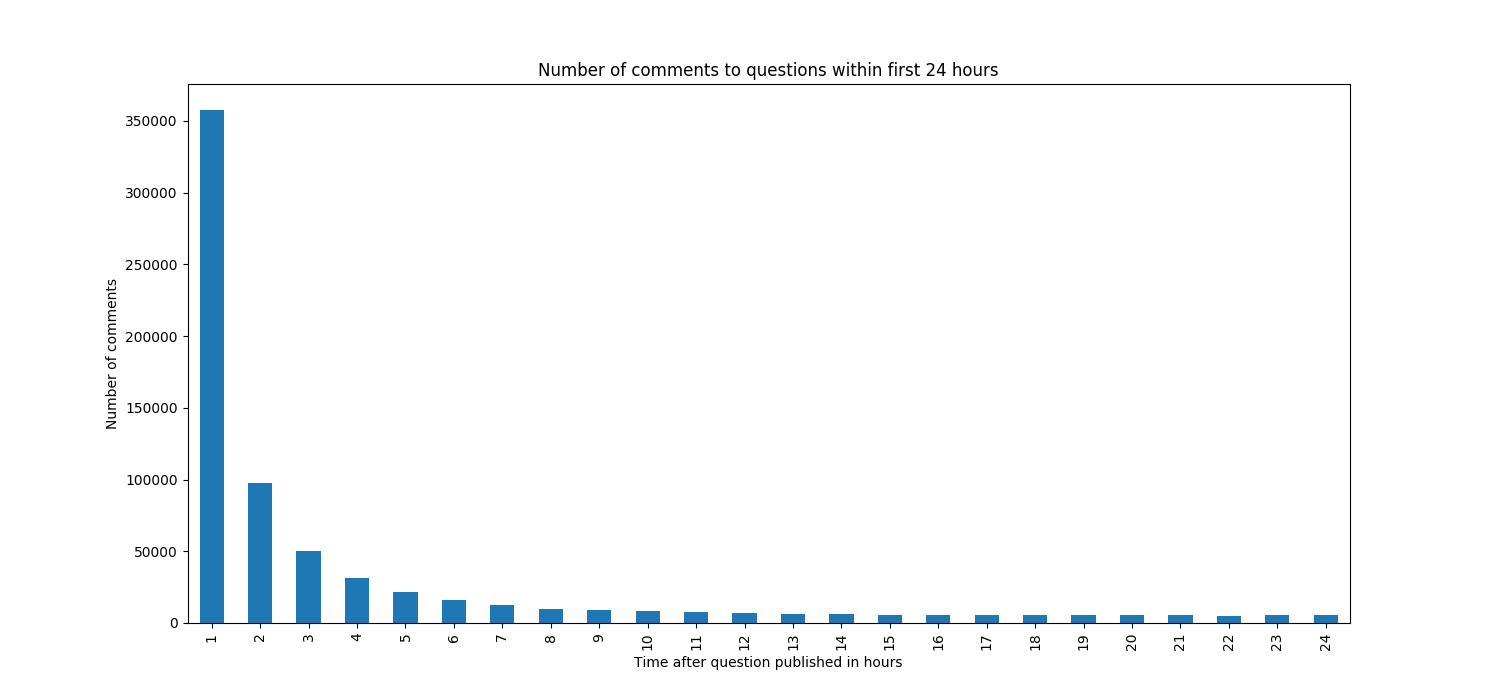

In [39]:
commentsWithin24hours = (
    commentTimeInSecs
    .withColumn('hours', ceil(col('commentTimeInSecs') / 3600))
    .groupBy('hours')
    .agg(count('*').alias('count'))
    .orderBy('hours')
    .limit(24)
).toPandas()

commentsWithin24hours.plot(
    title='Number of comments to questions within first 24 hours',
    x='hours',
    xlabel='Time after question published in hours',
    y='count',
    ylabel='Number of comments',
    kind='bar',
    legend=False,
    figsize=(15,7), 
)

%matplot plot

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

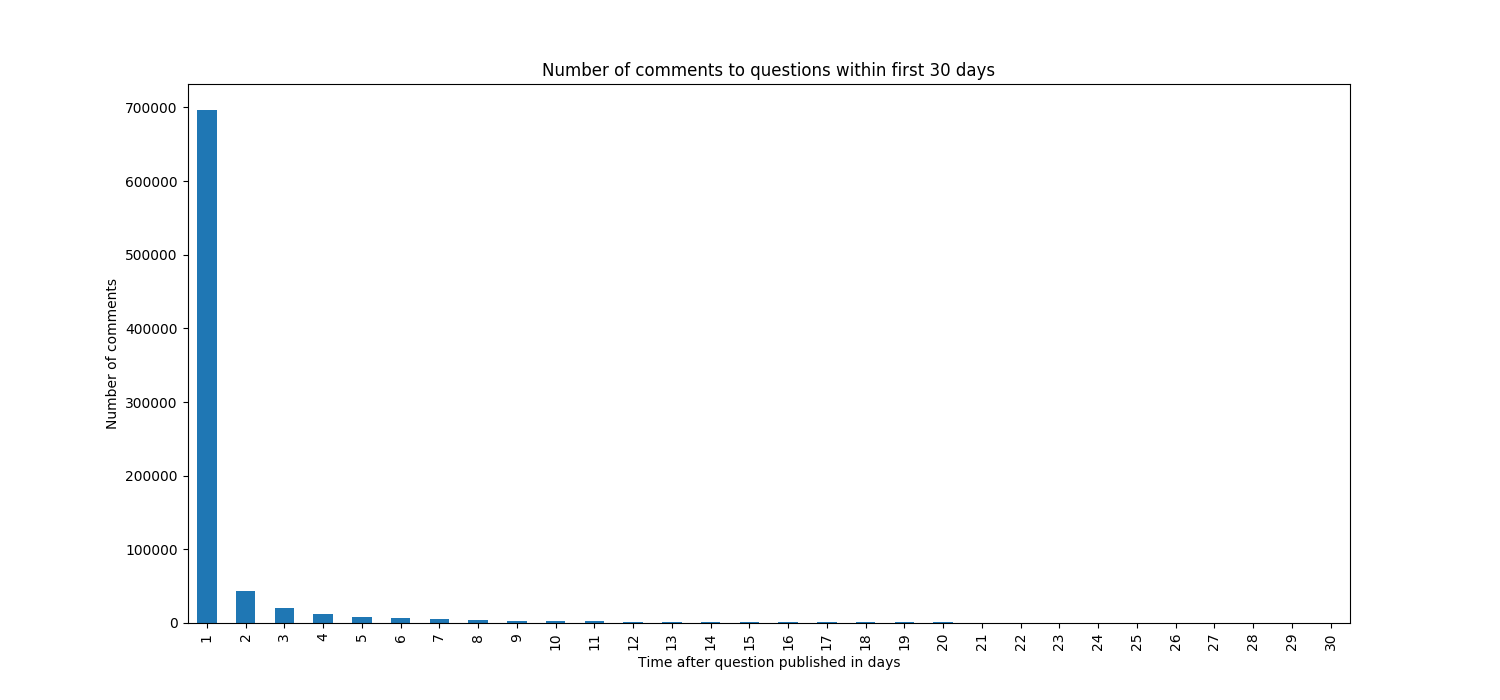

In [40]:
commentsWithin30days = (
    commentTimeInSecs
    .withColumn('days', ceil(col('commentTimeInSecs') / 86400))
    .groupBy('days')
    .agg(count('*').alias('count'))
    .orderBy('days')
    .limit(30)
).toPandas()

commentsWithin30days.plot(
    title='Number of comments to questions within first 30 days',
    x='days',
    xlabel='Time after question published in days',
    y='count',
    ylabel='Number of comments',
    kind='bar',
    legend=False,
    figsize=(15,7), 
)

%matplot plot

In [43]:
avgCommentTimeInDays = (
    questions.alias('questions')
    .join(comments.alias('comments'), col('questions.id') == col('comments.postId'))
    .select(
        col('questions.id'),
        col('questions.creationDate').alias('questionCreationDate'),
        col('comments.creationDate').alias('commentCreationDate')
    )
    .withColumn('commentTimeInSecs', unix_timestamp('commentCreationDate') - unix_timestamp('questionCreationDate'))
    .filter(col('commentTimeInSecs') > 0)
    .agg({'commentTimeInSecs': 'avg'}).collect()[0][0]/3600/24
)

avgCommentTimeInDays

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

53.92534363959123

In [21]:
avgAnswerTimeInDays = (
    questions.alias('questions')
    .join(answers.alias('answers'), col('questions.acceptedAnswerId') == col('answers.id'))
    .select(
        col('questions.id'),
        col('questions.creationDate').alias('questionCreationDate'),
        col('answers.creationDate').alias('answerCreationDate')
    )
    .withColumn('answerTimeInSecs', unix_timestamp('answerCreationDate') - unix_timestamp('questionCreationDate'))
    .agg({'answerTimeInSecs': 'avg'}).collect()[0][0]/3600/24
)

avgAnswerTimeInDays

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

29.04407220317314

In [47]:
(
spark
.read
.format('xml')
.option("rowTag", "row")
.load(usersXmlPath)
.select(
    col('_Id').alias('id'),
    col('_Reputation').alias('reputation'),
    col('_DisplayName').alias('displayName'),
    (col('_CreationDate').cast('timestamp')).alias('creationDate')
)
.write
.mode('overwrite')
.format('parquet')
.option('path', usersParquetPath)
.save()
)

users = spark.read.parquet(usersParquetPath).cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
reputationCommentsHourly = (
    questions.alias('questions')
    .join(comments.alias('comments'), col('questions.id') == col('comments.postId'))
    .join(users.alias('users'), col('users.id') == col('comments.userId'))
    .select(
        col('questions.id'),
        col('questions.creationDate').alias('questionCreationDate'),
        col('comments.creationDate').alias('commentCreationDate'),
        col('users.reputation').alias('commentReputation')
    )
    .withColumn('commentTime', unix_timestamp('commentCreationDate') - unix_timestamp('questionCreationDate'))
    .filter(col('commentTime') > 0)
    .withColumn('hours', ceil(col('commentTime') / 3600))
    .groupBy('hours')
    .agg({'commentReputation': 'avg'})
    .orderBy('hours')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

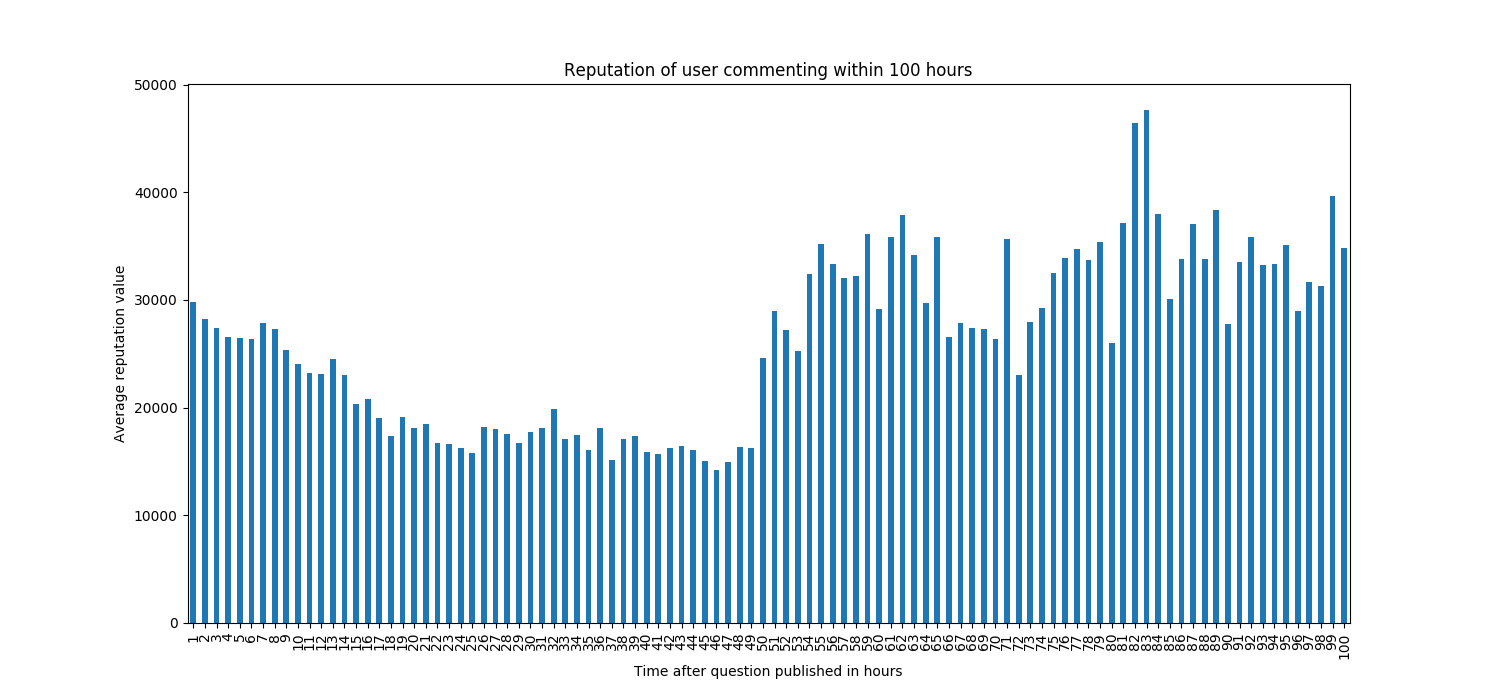

In [54]:
reputationCommentsHourly.limit(100).toPandas().plot(
    title='Reputation of user commenting within 100 hours',
    x='hours',
    xlabel='Time after question published in hours',
    y='avg(commentReputation)',
    ylabel='Average reputation value',
    kind='bar',
    legend=False,
    figsize=(15,7)
)

%matplot plot

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

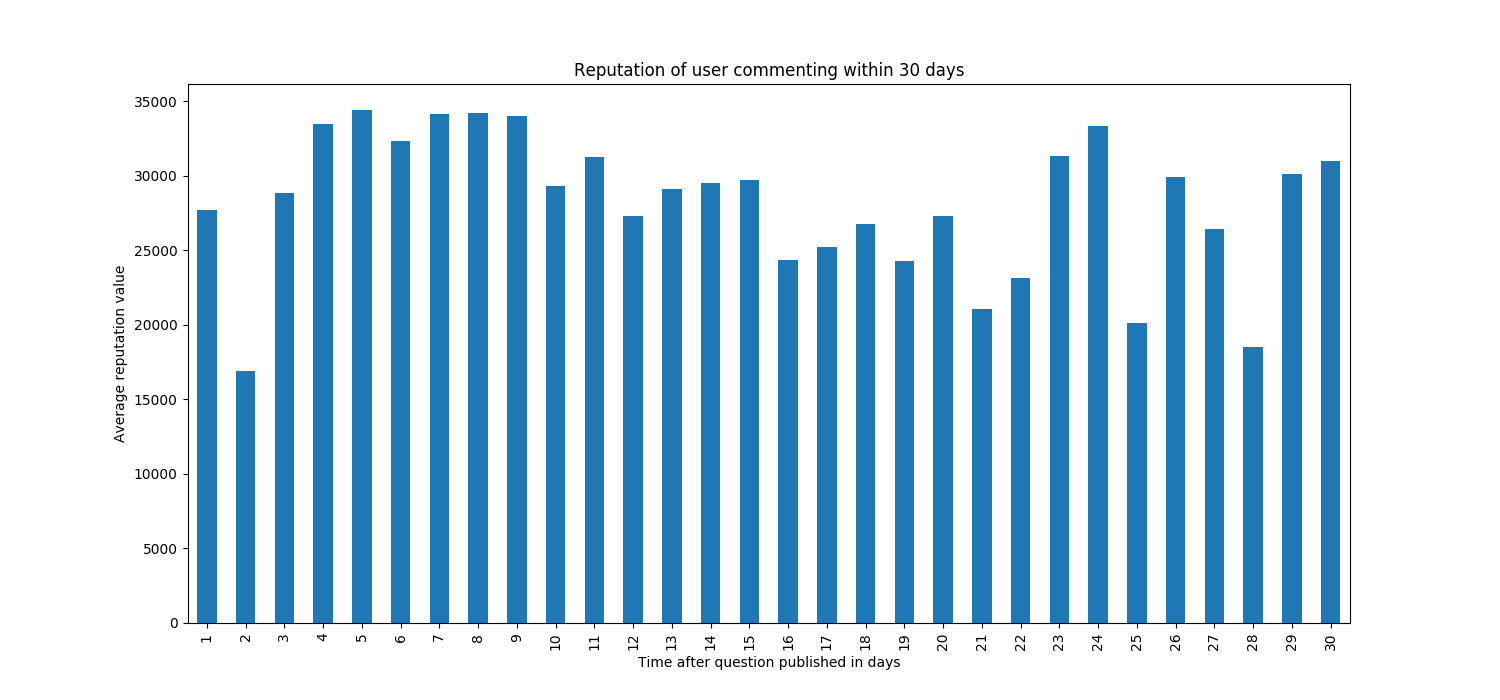

In [52]:
reputationCommentsDaily = (
    questions.alias('questions')
    .join(comments.alias('comments'), col('questions.id') == col('comments.postId'))
    .join(users.alias('users'), col('users.id') == col('comments.userId'))
    .select(
        col('questions.id'),
        col('questions.creationDate').alias('questionCreationDate'),
        col('comments.creationDate').alias('commentCreationDate'),
        col('users.reputation').alias('commentReputation')
    )
    .withColumn('commentTime', unix_timestamp('commentCreationDate') - unix_timestamp('questionCreationDate'))
    .filter(col('commentTime') > 0)
    .withColumn('days', ceil(col('commentTime') / 3600 / 24))
    .groupBy('days')
    .agg({'commentReputation': 'avg'})
    .orderBy('days')
)

reputationCommentsDaily.limit(30).toPandas().plot(
    title='Reputation of user commenting within 30 days',
    x='days',
    xlabel='Time after question published in days',
    y='avg(commentReputation)',
    ylabel='Average reputation value',
    kind='bar',
    legend=False,
    figsize=(15,7)
)

%matplot plot

In [26]:
posts.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+
|summary|               id|        postTypeId| acceptedAnswerId|      ownerUserId|          parentId|             score|        viewCount|
+-------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+
|  count|          1159934|           1159934|           192647|          1130323|            682102|           1159934|           470283|
|   mean|818774.4867690748|1.6108951026523923|747775.3927182879|319091.3533591725| 695777.3822038346| 2.781882417447889|5775.582532219961|
| stddev|491414.0436287983|0.5447973665771906|480786.0776756186|353765.7197700805|480105.04880466487|13.988797205182149|27673.66687286863|
|    min|                1|                 1|               42|               -1|                 1|               -69|                2|
|    max|          1691314|

In [27]:
commentBeforeAfterAcceptedAnswer = (
    questions.alias('questions')
    .join(comments.alias('comments'), col('questions.id') == col('comments.postId'))
    .join(answers.alias('answers'), col('questions.acceptedAnswerId') == col('answers.id'))
    .select(
        col('questions.id'),
        col('questions.creationDate').alias('questionCreationDate'),
        col('answers.id').alias('acceptedAnswerId'),
        col('answers.creationDate').alias('acceptedAnswerDate'),
        col('comments.creationDate').alias('commentCreationDate')
    )
    .withColumn('isCommentAfterAcceptedAnswer', unix_timestamp('commentCreationDate') > unix_timestamp('acceptedAnswerDate'))
    .groupBy('isCommentAfterAcceptedAnswer').agg(count('*').alias('count'))
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# Number of comments to questions that came before/after a question received accepted answer

commentBeforeAfterAcceptedAnswer.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------+------+
|isCommentAfterAcceptedAnswer| count|
+----------------------------+------+
|                        true|102765|
|                       false|206192|
+----------------------------+------+